In [1]:
import sys
sys.path.append("/media/hdd/viscent/SR-UNet")
from utils.inference_utils import *
from geomloss import SamplesLoss
from skopt import gp_minimize
import torchvision
import kornia as K

In [2]:
dhcp_train_loader, dhcp_test_loader, dhcp_val_loader = get_dataloader('dhcp',100,modality='t2')
hcp_train_loader, hcp_test_loader, hcp_val_loader = get_dataloader('hcp',100,modality='t2')

[11/10/22 10:24:55] INFO     colossalai - root - INFO: Creating dataset with 80 examples

                    INFO     colossalai - root - INFO: length of list_images_t1: 80

  0%|          | 0/80 [00:00<?, ?it/s]

[11/10/22 10:24:58] INFO     colossalai - root - INFO: Creating dataset with 20 examples

                    INFO     colossalai - root - INFO: length of list_images_t1: 20

  0%|          | 0/20 [00:00<?, ?it/s]

                    INFO     colossalai - root - INFO: Creating dataset with 80 examples

  0%|          | 0/80 [00:00<?, ?it/s]

[11/10/22 10:25:00] INFO     colossalai - root - INFO: Creating dataset with 20 examples

  0%|          | 0/20 [00:00<?, ?it/s]

In [3]:
model = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/unet_dhcp_t2/1600.pth')
model = model.cuda()
model.eval()

UNet3D(
  (encoders): ModuleList(
    (0): Encoder(
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(1, 1, eps=1e-05, affine=True)
          (conv): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
        (SingleConv2): SingleConv(
          (groupnorm): GroupNorm(1, 8, eps=1e-05, affine=True)
          (conv): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
      )
    )
    (1): Encoder(
      (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(1, 16, eps=1e-05, affine=True)
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
        

<Figure size 1440x720 with 0 Axes>

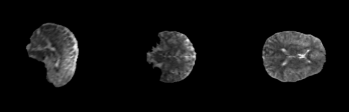

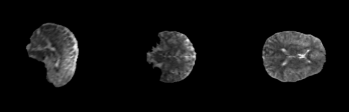

In [4]:
subject = tio.Subject(
    t2=tio.ScalarImage('/media/hdd/viscent/SR-UNet/inference/Inference_FLYWHEEL_BROWN/brainex_spm.nii'),
)
transform_1 = tio.Compose([
    tio.transforms.RescaleIntensity((0., 1.)),
    tio.transforms.ToCanonical(),
    tio.transforms.Resample((1.,1.,1.)),
])
subject = transform_1(subject)
edge_max = max(subject.t2.data.shape)
padding = ((edge_max - subject.t2.data.shape[1]) // 2, 
            (edge_max - subject.t2.data.shape[2]) // 2,
                (edge_max - subject.t2.data.shape[3]) // 2)
transform_2 = tio.Compose([
    tio.Pad(padding),
    tio.transforms.Resize((160,160,160)),
])
subject = transform_2(subject)
image_tensor = subject.t2.data.unsqueeze(0).float()
# image_tensor.transpose_(2,4)
# image_tensor = torch.flip(image_tensor, [2,3,4])
display_multiplanar_center(image_tensor[0,0,:,:,:].cpu().numpy())

<Figure size 1440x720 with 0 Axes>

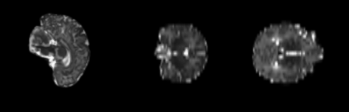

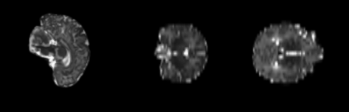

In [5]:
image_tensor_train, gt_tensor_train = iter(dhcp_train_loader).next()
display_multiplanar_center(image_tensor_train[0,0,:,:,:].cpu().numpy())

In [ ]:
latent_train = torch.zeros((500,1, 256, 10, 10, 10))
for i in tqdm(range(500)):
    image_tensor_train, gt_tensor_train = iter(dhcp_train_loader).next()
    latent_train[i] = kl_forward_latent(model, image_tensor_train.cuda())
np.save('/media/hdd/viscent/SR-UNet/inference/latent_train_dhcp.npy', latent_train.cpu().numpy())

In [6]:
latent_train = np.load('/media/hdd/viscent/SR-UNet/inference/latent_train_dhcp.npy')
latent_train = torch.from_numpy(latent_train).cuda()

In [ ]:
import functools
from skopt.plots import plot_convergence
def objective(x, latent_train, image_tensor):
    image_tensor = K.enhance.adjust_gamma(image_tensor,x[0])
    image_tensor = K.enhance.adjust_brightness(image_tensor,x[1])
    latent_input = kl_forward_latent(model, image_tensor.cuda())
    latent_input = latent_input.flatten().unsqueeze(0)
    latent_train = latent_train.flatten(start_dim=1)
    loss = SamplesLoss("sinkhorn", p=2, blur=.05, scaling=.95)(latent_input, latent_train)
    return loss.item()

_objective = functools.partial(objective, latent_train=latent_train, image_tensor=image_tensor)

res = gp_minimize(_objective,                  # the function to minimize
                  [(0, 10.0),(0,1.)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=30,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**3,   
                random_state=1234)  # the seed

plot_convergence(res)
image_opti = K.enhance.adjust_gamma(image_tensor,res.x[0])
image_opti = K.enhance.adjust_brightness(image_opti,res.x[1])
display_multiplanar_center(image_opti[0,0,:,:,:].cpu().numpy())

<Figure size 1440x720 with 0 Axes>

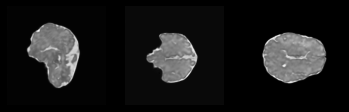

<Figure size 1440x720 with 0 Axes>

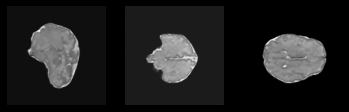

<Figure size 1440x720 with 0 Axes>

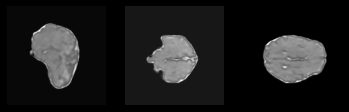

<Figure size 1440x720 with 0 Axes>

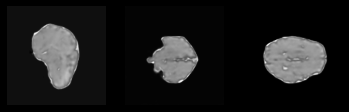

RuntimeError: CUDA out of memory. Tried to allocate 500.00 MiB (GPU 0; 23.67 GiB total capacity; 20.91 GiB already allocated; 6.00 MiB free; 20.95 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [7]:
output_tensor = model(image_tensor.cuda())
for i in range(10):
    output_tensor = model(output_tensor.cuda())
    display_multiplanar_center(output_tensor[0,0,:,:,:].detach().cpu().numpy())

In [ ]:
display_multiplanar_center(image_tensor[0,0,:,:,:].cpu().numpy())
output_vanilla = model(image_tensor.cuda())
output_opti = model(image_opti.cuda())
display_multiplanar_center(output_vanilla[0,0,:,:,:].detach().cpu().numpy())
display_multiplanar_center(output_opti[0,0,:,:,:].detach().cpu().numpy())
latent_vanilla = kl_forward_latent(model, image_tensor.cuda())
latent_opti = kl_forward_latent(model, image_opti.cuda())
loss_vanilla = SamplesLoss("sinkhorn", p=2, blur=.05, scaling=.95)(latent_vanilla.flatten().unsqueeze(0), latent_train.flatten(start_dim=1))
loss_opti = SamplesLoss("sinkhorn", p=2, blur=.05, scaling=.95)(latent_opti.flatten().unsqueeze(0), latent_train.flatten(start_dim=1))
print(loss_vanilla.item())
print(loss_opti.item())